In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/understanding_cloud_organization/sample_submission.csv
/kaggle/input/understanding_cloud_organization/train.csv
/kaggle/input/understanding_cloud_organization/train_images/65e3251.jpg
/kaggle/input/understanding_cloud_organization/train_images/76ee28f.jpg
/kaggle/input/understanding_cloud_organization/train_images/29dfbc9.jpg
/kaggle/input/understanding_cloud_organization/train_images/aa0d0c5.jpg
/kaggle/input/understanding_cloud_organization/train_images/e6fd8d4.jpg
/kaggle/input/understanding_cloud_organization/train_images/5607f7b.jpg
/kaggle/input/understanding_cloud_organization/train_images/ca6b9c5.jpg
/kaggle/input/understanding_cloud_organization/train_images/ed308d4.jpg
/kaggle/input/understanding_cloud_organization/train_images/e1b35d8.jpg
/kaggle/input/understanding_cloud_organization/train_images/5eb8563.jpg
/kaggle/input/understanding_cloud_organization/train_images/795b4a3.jpg
/kaggle/input/understanding_cloud_organization/train_images/fe07e1c.jpg
/kaggle/in

# Libraries

In [2]:
!pip uninstall tensorflow -y
!pip install tensorflow==1.15.3

!pip uninstall keras -y
!pip install keras==2.2.5

!pip install segmentation-models --quiet
!pip install -U albumentations>=0.3.0

Found existing installation: tensorflow 2.3.0
Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 110.5 MB 26 kB/s 
     |████████████████████████████████| 503 kB 40.6 MB/s 
     |████████████████████████████████| 3.8 MB 28.2 MB/s 
     |████████████████████████████████| 50 kB 4.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=9eeec0db41c6886ae07dc3f045019553502100674cfe1c2b8d01391d1c44990d
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard

In [3]:
import numpy as np
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import math

import albumentations as A

In [4]:
import keras
from keras.utils import Sequence

import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


# Config

In [5]:
main_path      = "/kaggle/input/understanding_cloud_organization/"
batch_size     = 16
image_h        = 224
image_w        = 224
len_train_data = 1000
len_val_data   = 100

# Utilities

In [6]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    
    if type(mask_rle) != str:
        return np.zeros(shape, dtype=np.uint8)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    return img.reshape(shape, order='F')

def plot_img_and_mask(img, mask):
    fig, axs = plt.subplots(1, 5, figsize=(20,15))
    
    axs[0].imshow(img)
    axs[0].set_title('image')
    
    axs[1].imshow(mask[..., 0])
    axs[1].set_title('fish')
    axs[2].imshow(mask[..., 1])
    axs[2].set_title('flower')
    axs[3].imshow(mask[..., 2])
    axs[3].set_title('gravel')
    axs[4].imshow(mask[..., 3])
    axs[4].set_title('sugar')
            
    plt.show()
    
def plot_predict_mask(img, true_mask, pred_mask):
    fig, axs = plt.subplots(2, 5, figsize=(20,8))
    
    axs[0, 0].imshow(img)
    axs[0, 0].set_title('image')
    
    axs[0, 1].imshow(true_mask[..., 0])
    axs[0, 1].set_title('true_fish')
    axs[0, 2].imshow(true_mask[..., 1])
    axs[0, 2].set_title('true_flower')
    axs[0, 3].imshow(true_mask[..., 2])
    axs[0, 3].set_title('true_gravel')
    axs[0, 4].imshow(true_mask[..., 3])
    axs[0, 4].set_title('true_sugar')
    
    axs[1, 0].imshow(img)
    axs[1, 0].set_title('image')
    
    axs[1, 1].imshow(pred_mask[..., 0])
    axs[1, 1].set_title('pred_fish')
    axs[1, 2].imshow(pred_mask[..., 1])
    axs[1, 2].set_title('pred_flower')
    axs[1, 3].imshow(pred_mask[..., 2])
    axs[1, 3].set_title('pred_gravel')
    axs[1, 4].imshow(pred_mask[..., 3])
    axs[1, 4].set_title('pred_sugar')
    
    plt.show()
    
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    
    axs[0].plot(history['loss'],     label = 'train_loss')
    axs[0].plot(history['val_loss'], label = 'val_loss')
    axs[0].legend()
    axs[1].plot(history['iou_score'],     label = 'train_acc')
    axs[1].plot(history['val_iou_score'], label = 'val_acc')
    axs[1].legend()
    
    
    plt.show()

# Check Data

In [7]:
train_pd = pd.read_csv(main_path + "train.csv")
train_pd

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
...,...,...
22179,ffd6680.jpg_Sugar,NaN
22180,ffea4f4.jpg_Fish,NaN
22181,ffea4f4.jpg_Flower,1194860 675 1196260 675 1197660 675 1199060 67...
22182,ffea4f4.jpg_Gravel,NaN


In [8]:
submit = pd.read_csv(main_path + "sample_submission.csv")
submit

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 1
1,002f507.jpg_Flower,1 1
2,002f507.jpg_Gravel,1 1
3,002f507.jpg_Sugar,1 1
4,0035ae9.jpg_Fish,1 1
...,...,...
14787,ffe0620.jpg_Sugar,1 1
14788,fff3c5c.jpg_Fish,1 1
14789,fff3c5c.jpg_Flower,1 1
14790,fff3c5c.jpg_Gravel,1 1


# Dataset and Dataloader

In [9]:
class Dataset:
    
    def __init__(
            self,
            dataframe,
            images_dir,
            augmentation = None, 
    ): 
        self.dataframe    = dataframe.reset_index(drop=True)
        self.images_dir   = images_dir
        self.augmentation = augmentation
        
    def __getitem__(self, i):
        
        #read img
        img_name = self.images_dir + self.dataframe["Image_Label"][i*4].split('_')[0]
        img      = plt.imread(img_name)
        
        #read mask
        str_fish    = self.dataframe["EncodedPixels"][i*4 + 0]
        str_flower  = self.dataframe["EncodedPixels"][i*4 + 1]
        str_gravel  = self.dataframe["EncodedPixels"][i*4 + 2]
        str_sugar   = self.dataframe["EncodedPixels"][i*4 + 3]
        
        mask_fish   = rle_decode(str_fish)
        mask_flower = rle_decode(str_flower)
        mask_gravel = rle_decode(str_gravel)
        mask_sugar  = rle_decode(str_sugar)
        
        masks = [mask_fish, mask_flower, mask_gravel, mask_sugar]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']
        
        return img, mask
        
    def __len__(self):
        return len(self.dataframe) // 4

In [10]:
train_aug = A.Compose([
    A.Resize(image_h, image_w)
])

val_aug = A.Compose([
    A.Resize(image_h, image_w)
])

In [11]:
train_dataset = Dataset(train_pd[0:len_train_data*4],                                 main_path + "train_images/", augmentation = train_aug)
val_dataset   = Dataset(train_pd[len_train_data*4:(len_train_data + len_val_data)*4], main_path + "train_images/", augmentation = val_aug)

In [12]:
img0, mask0 = train_dataset[0]
img1, mask1 = train_dataset[1]
img2, mask2 = train_dataset[2]
img3, mask3 = train_dataset[3]

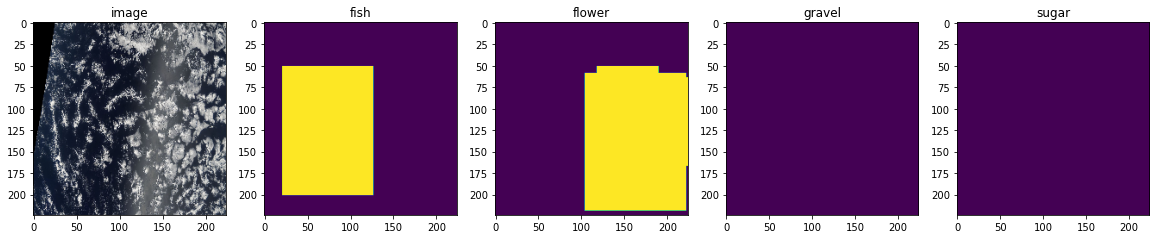

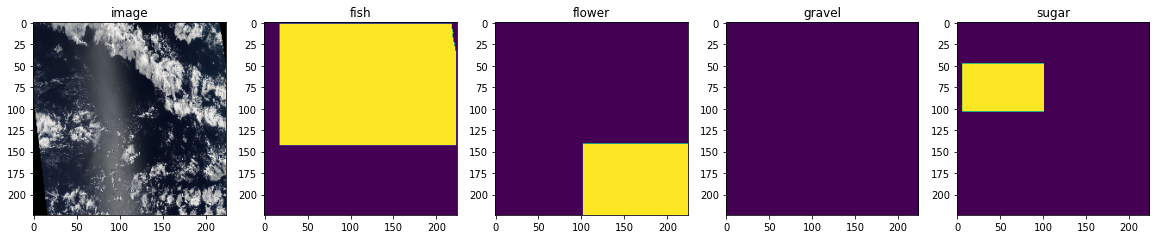

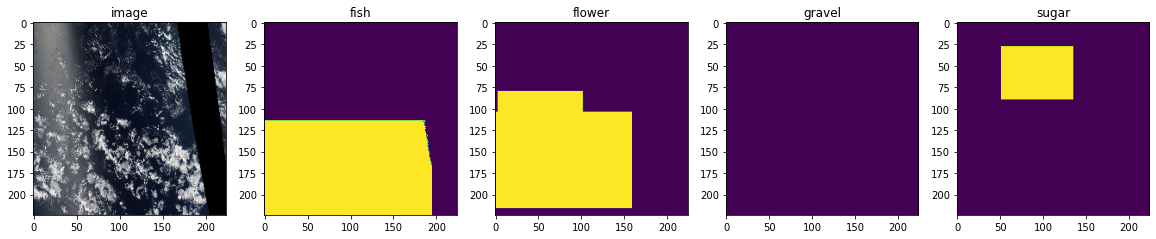

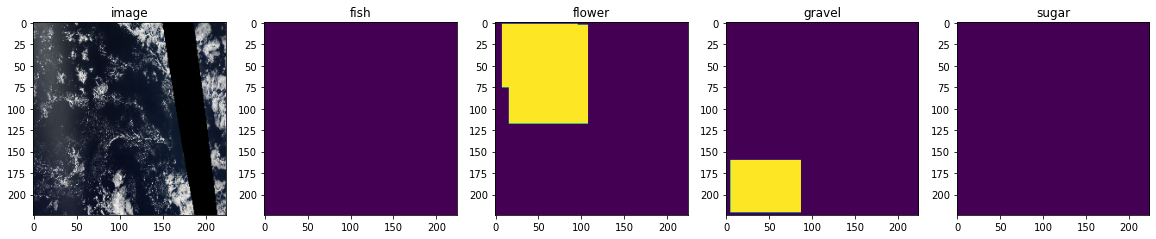

In [13]:
plot_img_and_mask(img0, mask0)
plot_img_and_mask(img1, mask1)
plot_img_and_mask(img2, mask2)
plot_img_and_mask(img3, mask3)

In [14]:
class Dataloader(Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [15]:
train_dataloader = Dataloader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader   = Dataloader(val_dataset,   batch_size = batch_size, shuffle = False)

# Model

In [16]:
model = sm.Unet('resnet34', input_shape=(image_h, image_w, 3), classes=4, activation='sigmoid')

85524480/85521592 [==============================] - 1s 0us/step


In [17]:
model.compile(
    keras.optimizers.Adam(),
    sm.losses.JaccardLoss(),
    [sm.metrics.IOUScore(threshold=0.5)]
)

In [18]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=40,
    validation_data=val_dataloader, 
    validation_steps=len(val_dataloader),
)

Epoch 1/40
62/62 [==============================] - 753s 12s/step - loss: 0.7729 - iou_score: 0.2631 - val_loss: 0.8587 - val_iou_score: 0.1378
Epoch 2/40
62/62 [==============================] - 770s 12s/step - loss: 0.6817 - iou_score: 0.3301 - val_loss: 0.8035 - val_iou_score: 0.1971
Epoch 3/40
62/62 [==============================] - 761s 12s/step - loss: 0.6596 - iou_score: 0.3437 - val_loss: 0.7245 - val_iou_score: 0.2806
Epoch 4/40
62/62 [==============================] - 765s 12s/step - loss: 0.6420 - iou_score: 0.3611 - val_loss: 0.7141 - val_iou_score: 0.2881
Epoch 5/40
62/62 [==============================] - 773s 12s/step - loss: 0.6214 - iou_score: 0.3810 - val_loss: 0.6922 - val_iou_score: 0.3089
Epoch 6/40
62/62 [==============================] - 779s 13s/step - loss: 0.6092 - iou_score: 0.3925 - val_loss: 0.7669 - val_iou_score: 0.2330
Epoch 7/40
62/62 [==============================] - 808s 13s/step - loss: 0.5960 - iou_score: 0.4049 - val_loss: 0.8112 - val_iou_score:

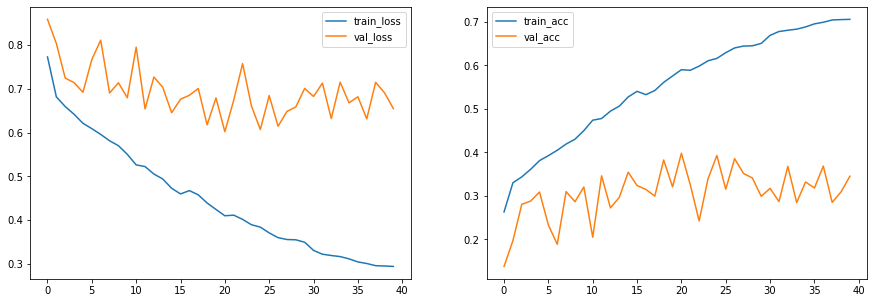

In [19]:
plot_history(history.history)

# Predict on Train

In [20]:
train_batch = train_dataloader[0]
imgs        = train_batch[0]
true_masks  = train_batch[1]

In [21]:
pred_masks = model.predict(imgs)

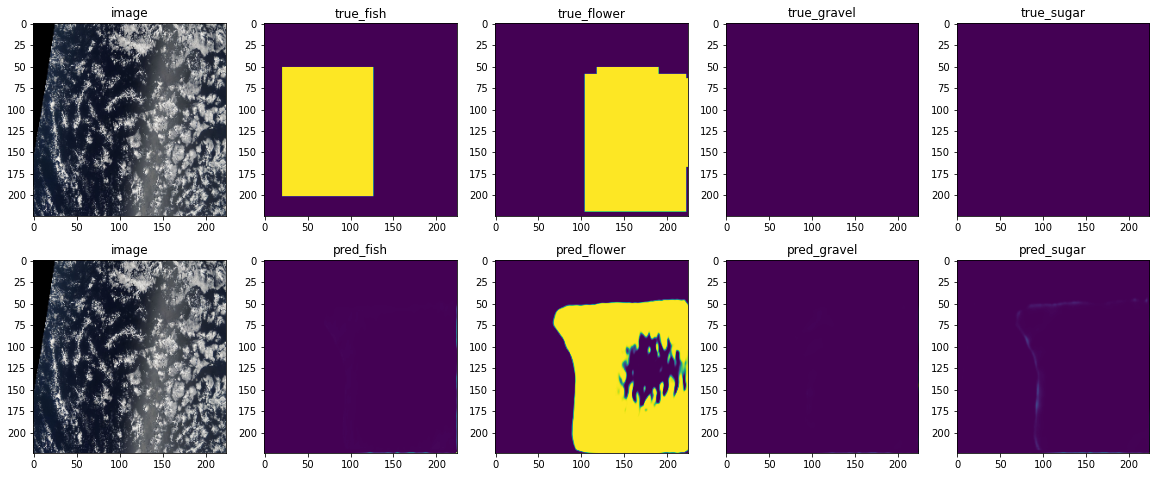

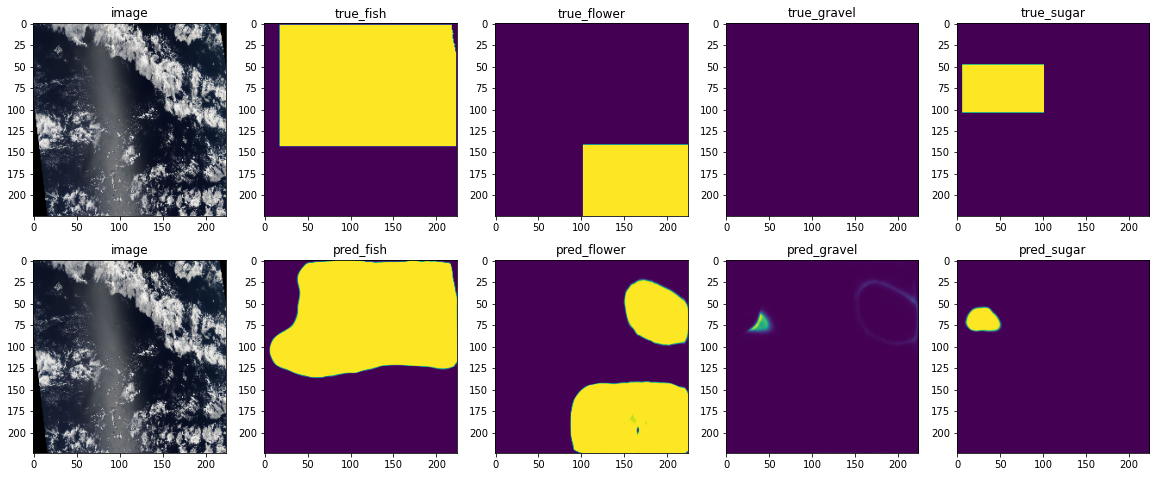

In [22]:
plot_predict_mask(imgs[0], true_masks[0], pred_masks[0])
plot_predict_mask(imgs[1], true_masks[1], pred_masks[1])

# Predict on Val

In [23]:
val_batch  = val_dataloader[0]
imgs       = val_batch[0]
true_masks = val_batch[1]

In [24]:
pred_masks = model.predict(imgs)

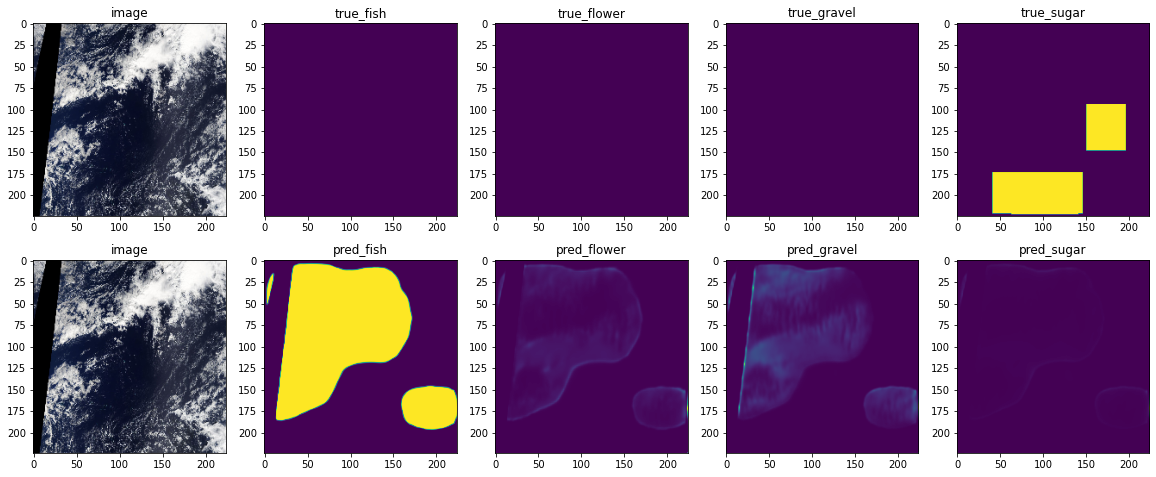

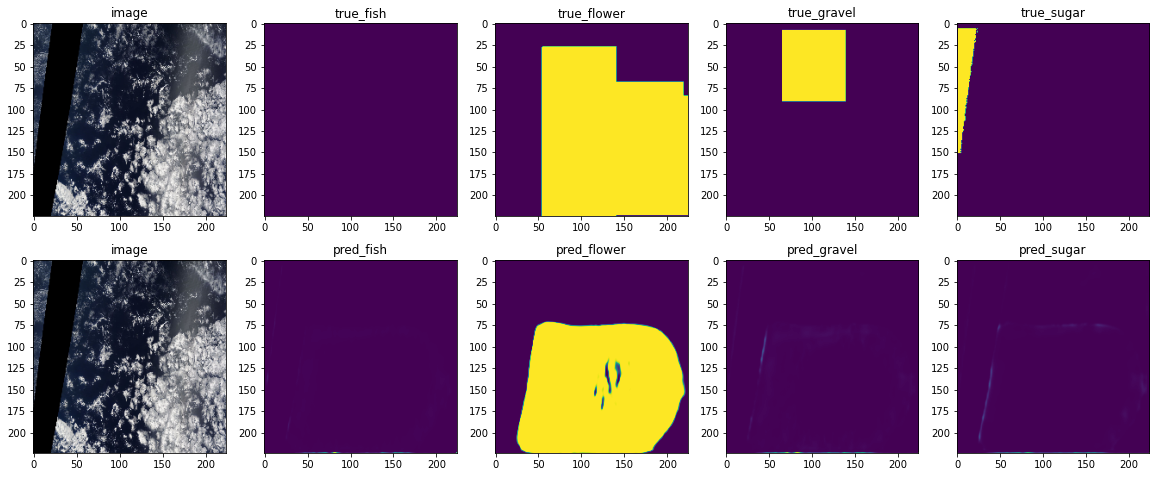

In [25]:
plot_predict_mask(imgs[0], true_masks[0], pred_masks[0])
plot_predict_mask(imgs[1], true_masks[1], pred_masks[1])